# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Functions

In [2]:
class AdultExtractor(BaseEstimator, TransformerMixin):
    """
    A custom class to create a new 'Adult' column from the 'Age' column.
    This custom class is used in the data preprocessing pipeline.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Adult'] = X['Age'].apply(lambda x: True if x >= 18 else False)
    
        return X[['Adult']]


class TitleExtractor(BaseEstimator, TransformerMixin):
    """
    A custom class to create a new 'Title' column from the 'Name' column.
    This custom class is used in the data preprocessing pipeline.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        titles = [
            'mr', 'miss', 'mrs', 'master', 'dr', 'rev', 'major', 'col', 'capt',
            'ms', 'sir', 'lady'
        ]
        
        X['Title'] = X['Name'].apply(
            lambda x: next(
                (title for title in titles if title in x.lower()), 'none'
            )
        )
    
        return X[['Title']]

# Read Data

In [3]:
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')

# Visualize Data

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


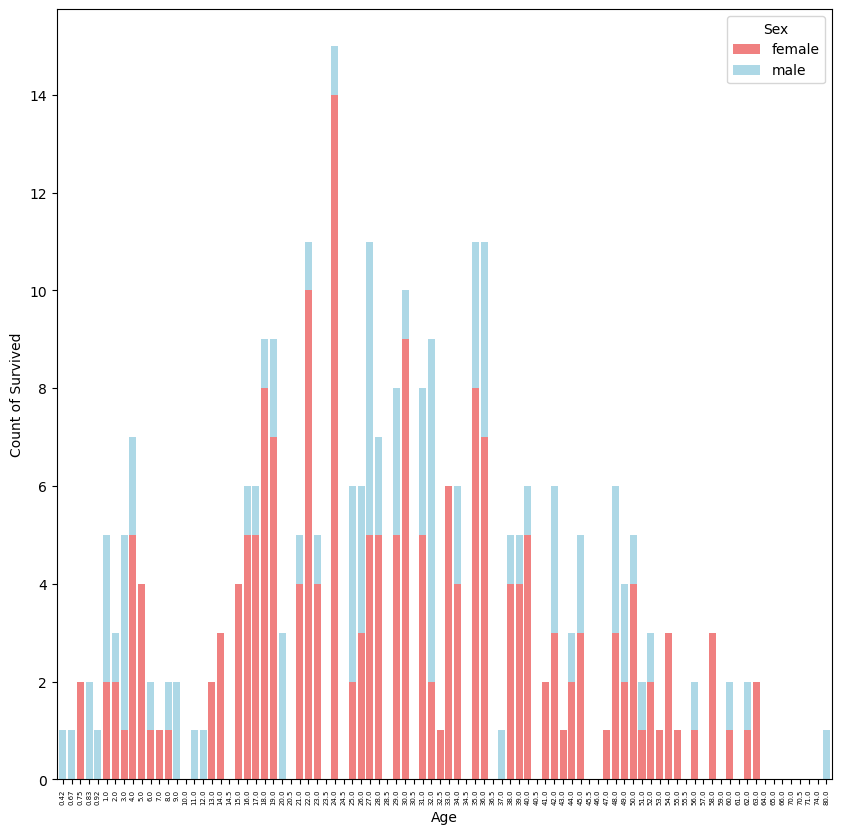

In [6]:
# counts of surviving passengers by age, split by sex
survived_counts = train_df.groupby(['Age', 'Sex'])['Survived'].sum().unstack()
survived_counts.plot(
    kind='bar', 
    stacked=True, 
    color=['lightcoral', 'lightblue'], 
    width=0.8, 
    figsize=(10, 10)
)

plt.xlabel('Age')
plt.ylabel('Count of Survived')
plt.xticks(fontsize=5)

plt.show()

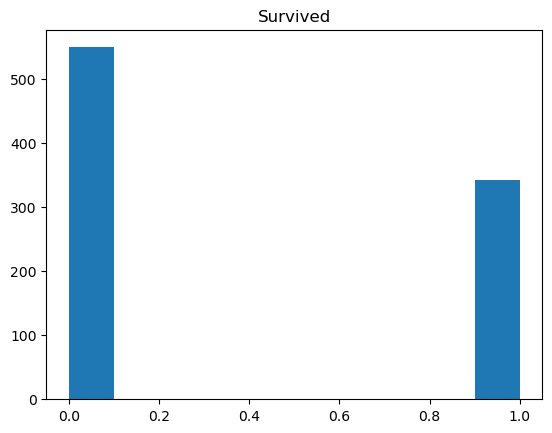

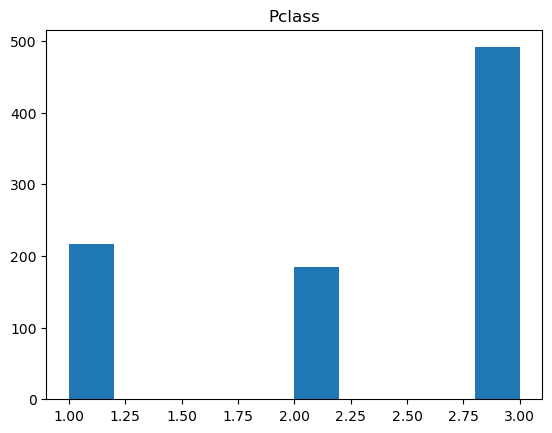

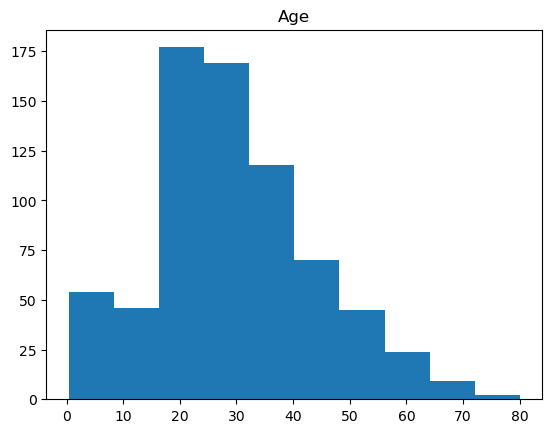

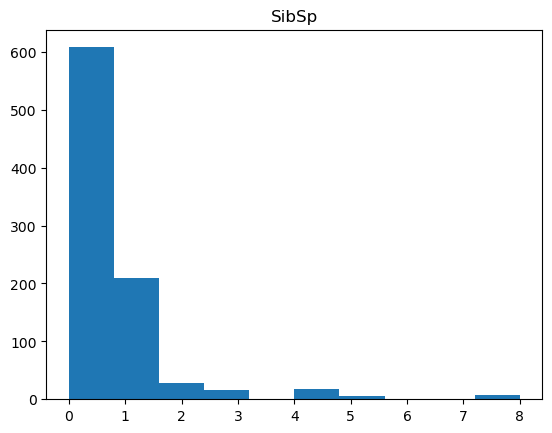

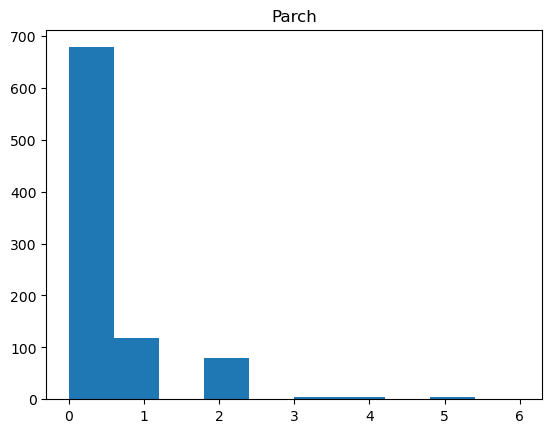

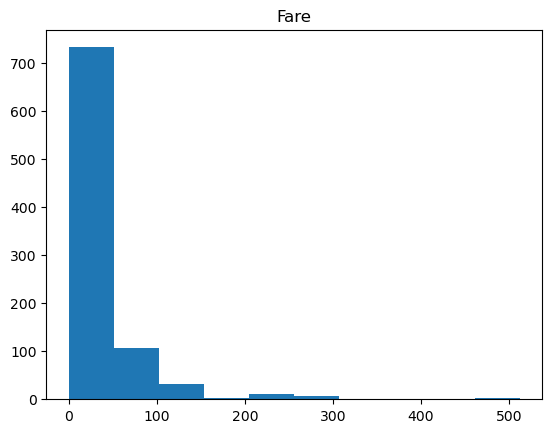

In [7]:
# histograms of numerical data
for i in train_df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]:
    plt.hist(train_df[i])
    plt.title(i)
    plt.show()

In [8]:
# average values of numerical columns, split by survived or not
pd.pivot_table(
    train_df, 
    index='Survived', 
    values=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
)

,Age,Fare,Parch,Pclass,SibSp
Survived,,,,,
0,30.626179,22.117887,0.329690,2.531876,0.553734
1,28.343690,48.395408,0.464912,1.950292,0.473684


# Data Pipeline

In [9]:
# selecting and splitting the data
X = train_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Name', 'Age']]
y = train_df['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# imputing for nulls of the 'Age' column
numeric_features = ['Age']
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# creating a new 'Title' column from 'Name' and encoding the values
title_pipeline = Pipeline([
    ('title_extractor', TitleExtractor()),
    ('one_hot_titles', OneHotEncoder(handle_unknown='ignore'))
])

# creating a new 'Adult' column from 'Age' and encoding the values
adult_pipeline = Pipeline([
    ('adult_extractor', AdultExtractor()),
    ('one_hot_titles', OneHotEncoder(handle_unknown='ignore'))
])

# encoding categorical values of chosen columns
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch']
categorical_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

# stringing all the pipelines together
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_features),
    ('title', title_pipeline, ['Name']),
    ('adult', adult_pipeline, ['Age']),
    ('categorical', categorical_pipeline, categorical_features),
])

# defining the classifier model
rfc = RandomForestClassifier()

# creating the whole model with the preprocessing pipeline and classifier
raw_model = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', rfc)
])

# GridSearchCV

In [11]:
# defining parameters to search through
parameter_grid = {
    'random_forest__n_estimators': range(1, 101, 20),
    'random_forest__max_depth': range(1, 21),
    'random_forest__random_state': [1]
}

# fitting grid search model
grid_search_model = GridSearchCV(raw_model, parameter_grid, scoring='accuracy')
grid_search_model.fit(X_train, y_train)

# getting the best parameters from training
print(grid_search_model.best_params_)
print(grid_search_model.best_score_)

{'random_forest__max_depth': 6, 'random_forest__n_estimators': 81, 'random_forest__random_state': 1}
0.8215896779277061


In [12]:
# selecting the best model
model = grid_search_model.best_estimator_

# Model Fitting & Performance

In [13]:
y_pred = model.predict(X_valid)

Accuracy: 0.8044692737430168
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



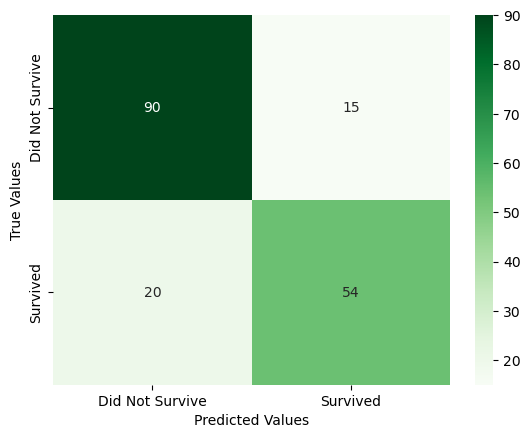

In [14]:
# scoring our predictions on the validation data
cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(cm, annot=True, cmap='Greens')

plt.xticks(ticks=[0.5, 1.5], labels=['Did Not Survive', 'Survived'])
plt.yticks(ticks=[0.5, 1.5], labels=['Did Not Survive', 'Survived'])

plt.xlabel('Predicted Values')
plt.ylabel('True Values')

accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_valid, y_pred))

# Kaggle Submission

In [15]:
X_test = test_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Name', 'Age']]

y_final = model.predict(X_test)

output_df = pd.DataFrame(
    {'PassengerId': test_df['PassengerId'], 'Survived': y_final}
)

output_df.to_csv('./results.csv', index=False)

output_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Save Model & Export Environment

In [16]:
with open('titanic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [17]:
!conda list --export > environment.txt